In [180]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import SVC

from bayes_opt import BayesianOptimization
from bayes_opt.util import Colours

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors, cm 

from math import log, floor, sqrt

copper = mpl.cm.copper 
cNorm  = colors.Normalize(vmin=-1, vmax=0)
scalarMap = cm.ScalarMappable(norm=cNorm, cmap=copper)

In [181]:
def cost_per_model(pct, algo='svm'): 
    x = [i for i in range(1,101, 1)] 
 
    if algo == 'rf': 
        nlogn = [i*log(i) for i in x]
        return nlogn[99]/nlogn[int(pct*100) - 1]
    if algo == 'svm':
        n_n = [i*i for i in x]
        return n_n[99]/n_n[int(pct*100) - 1] 
    


def budget_division(budget, how='equal', steps=3, lower=0.4):
    
    def normalizing_factor(lst, budget):
        '''sum(lst).X = budget'''
        return budget / sum(lst)
    
    if how == 'equal':
        return [int(budget/steps) for _ in range(steps)]
    else:
        slices = [budget/(1+s) for s in range(steps)]
        norm_factor = normalizing_factor(slices, budget)
        normalized_slices = [norm_factor*s for s in slices]
        
        if how == 'linear_asc':
            return normalized_slices
        if how == 'linear_desc':
            return normalized_slices[::-1]
        

def models_at_sample_size(budget, sample_size, algo):
    return int(budget*cost_per_model(sample_size, algo))


def size(i, lower=0.4, steps=3):
    #i += 1
    return lower + i * (1 - lower)/(steps - 1)

In [182]:
def get_data():
    """Synthetic binary classification dataset."""
    data, targets = make_classification(
        n_samples=5_000,
        n_features=22,
        n_informative=12,
        n_redundant=4, 
        random_state=0,
    )
    return data, targets

In [214]:
def rfc_cv(n_estimators, min_samples_split, max_features, data, targets): 
    estimator = RFC(
        n_estimators=n_estimators,
        min_samples_split=min_samples_split,
        max_features=max_features,
        random_state=2
    ) 
    
    cval = cross_val_score(estimator, data, targets,
                           scoring='neg_log_loss', cv=3)
    return cval.mean()
 

def optimize_rfc(data, targets, level, n_iter=10, bounds=None, probe=None):
    """Apply Bayesian Optimization to Random Forest parameters."""
    def rfc_crossval(n_estimators, min_samples_split, max_features): 
        return rfc_cv(
            n_estimators=int(n_estimators),
            min_samples_split=float(min_samples_split),
            max_features=max(min(max_features, 0.999), 1e-3), 
            data=data,
            targets=targets,
        )

    optimizer = BayesianOptimization(
        f=rfc_crossval,
        pbounds={
            "n_estimators": (10, 250),
            "min_samples_split": (0.01, 0.999),
            "max_features": (0.1, 0.999), 
        },
        random_state=1234,
        verbose=2
    ) 
    
    if len(params) > 0:
        for p in params: 
            optimizer.probe(
            params=p,
            lazy=True,
            )
    
    
    optimizer.maximize(init_points=2, n_iter=n_iter, acq="ucb", kappa=20/level) 
    
    x0_obs = np.array([[res["params"]["max_features"]] for res in optimizer.res]) 
    x1_obs = np.array([[res["params"]["min_samples_split"]] for res in optimizer.res])
    x2_obs = np.array([[res["params"]["n_estimators"]] for res in optimizer.res]) 
    y_obs = np.array([res["target"] for res in optimizer.res]) 
     
    #plt.scatter(x0_obs, x1_obs, c=scalarMap.to_rgba(y_obs), 
    #            s=level*5, alpha=level*0.3, label=str(len(x0_obs)))     
    #plt.show()
    fig, ax = plt.subplots(3, 1)
    ax[0].scatter(x0_obs, x1_obs, c=scalarMap.to_rgba(y_obs))    
    ax[1].scatter(x0_obs, x2_obs, c=scalarMap.to_rgba(y_obs))
    ax[2].scatter(x1_obs, x2_obs, c=scalarMap.to_rgba(y_obs))
    plt.show() 
    
    #plt.matshow(optimizer._gp.L_)
    #plt.show()
    
    n_points = floor(sqrt(n_iter))
    n_points = 5
    idx = y_obs.argsort()[-n_points:][::-1]
    to_explore = [[x0_obs[i], x1_obs[i], x2_obs[i]] for i in idx]      
    return to_explore

--- Optimizing Random Forest: 170 models; budget:54.54545454545454 --- 
|   iter    |  target   | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------
|  1        | -0.648    |  0.2722   |  0.6253   |  115.1    |
|  2        | -0.6931   |  0.806    |  0.7814   |  75.42    |
|  3        | -0.6931   |  0.999    |  0.999    |  250.0    |
|  4        | -0.4837   |  0.6102   |  0.1777   |  110.5    |
|  5        | -0.6931   |  0.8985   |  0.9366   |  73.52    |
|  6        | -0.4091   |  0.1      |  0.01     |  10.0     |
|  7        | -0.3163   |  0.999    |  0.01     |  188.4    |
|  8        | -0.3167   |  0.999    |  0.01     |  156.2    |
|  9        | -0.6931   |  0.1      |  0.999    |  219.8    |
|  10       | -0.3993   |  0.1      |  0.01     |  37.27    |
|  11       | -0.6931   |  0.1      |  0.999    |  172.1    |
|  12       | -0.3967   |  0.1      |  0.01     |  137.5    |
|  13       | -0.3988   |  0.1      |  0.01     |  52.93    

|  80       | -0.6931   |  0.9787   |  0.9954   |  185.6    |
|  81       | -0.3491   |  0.9936   |  0.0174   |  39.69    |
|  82       | -0.3159   |  0.999    |  0.01     |  239.2    |
|  83       | -0.6931   |  0.9675   |  0.9649   |  107.9    |
|  84       | -0.3164   |  0.999    |  0.01     |  250.0    |
|  85       | -0.4558   |  0.1818   |  0.06381  |  125.2    |
|  86       | -0.4484   |  0.1108   |  0.03528  |  197.5    |
|  87       | -0.3994   |  0.1      |  0.01     |  21.92    |
|  88       | -0.4056   |  0.191    |  0.0371   |  118.8    |
|  89       | -0.396    |  0.1      |  0.01     |  202.9    |
|  90       | -0.3358   |  0.9884   |  0.01854  |  105.8    |
|  91       | -0.3638   |  0.999    |  0.01     |  10.0     |
|  92       | -0.3963   |  0.1      |  0.01     |  190.7    |
|  93       | -0.397    |  0.1      |  0.01     |  57.3     |
|  94       | -0.4691   |  0.1035   |  0.05317  |  173.1    |
|  95       | -0.3951   |  0.1      |  0.01     |  241.7    |
|  96   

|  161      | -0.3713   |  0.9849   |  0.04466  |  248.6    |
|  162      | -0.3532   |  0.8002   |  0.02926  |  91.28    |
|  163      | -0.344    |  0.9858   |  0.02392  |  153.9    |
|  164      | -0.3162   |  0.999    |  0.01     |  245.7    |
|  165      | -0.3742   |  0.1834   |  0.01939  |  193.9    |
|  166      | -0.3975   |  0.1      |  0.01     |  67.83    |
|  167      | -0.3969   |  0.1      |  0.01     |  122.3    |
|  168      | -0.6931   |  0.999    |  0.999    |  53.27    |
|  169      | -0.397    |  0.1      |  0.01     |  147.7    |
|  170      | -0.3608   |  0.9574   |  0.03538  |  231.5    |
|  171      | -0.6931   |  0.1      |  0.999    |  200.7    |
|  172      | -0.3476   |  0.9949   |  0.01083  |  14.23    |


<Figure size 720x1152 with 0 Axes>

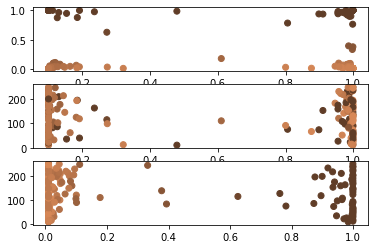

--- Optimizing Random Forest: 42 models; budget:27.27272727272727 --- 
|   iter    |  target   | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------
|  1        | -0.3118   |  0.999    |  0.01     |  239.2    |
|  2        | -0.3119   |  0.999    |  0.01     |  245.7    |
|  3        | -0.312    |  0.999    |  0.01     |  188.4    |
|  4        | -0.3119   |  0.999    |  0.01     |  250.0    |
|  5        | -0.3122   |  0.999    |  0.01     |  195.7    |
|  6        | -0.6489   |  0.2722   |  0.6253   |  115.1    |
|  7        | -0.6932   |  0.806    |  0.7814   |  75.42    |
|  8        | -0.6932   |  0.1      |  0.7433   |  10.0     |
|  9        | -0.6931   |  0.1      |  0.999    |  161.5    |
|  10       | -0.3156   |  0.999    |  0.01     |  40.0     |
|  11       | -0.312    |  0.999    |  0.01     |  136.2    |
|  12       | -0.6932   |  0.1      |  0.999    |  56.59    |
|  13       | -0.6931   |  0.1      |  0.999    |  217.0    |

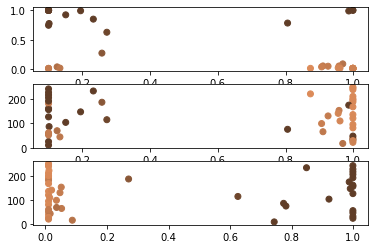

--- Optimizing Random Forest: 18 models; budget:18.181818181818183 --- 
|   iter    |  target   | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------
|  1        | -0.2999   |  0.8736   |  0.01132  |  221.7    |
|  2        | -0.2963   |  0.999    |  0.01     |  239.2    |
|  3        | -0.2963   |  0.999    |  0.01     |  245.7    |
|  4        | -0.2961   |  0.999    |  0.01     |  250.0    |
|  5        | -0.2963   |  0.999    |  0.01     |  211.5    |
|  6        | -0.6486   |  0.2722   |  0.6253   |  115.1    |
|  7        | -0.6931   |  0.806    |  0.7814   |  75.42    |
|  8        | -0.5163   |  0.6785   |  0.1961   |  10.01    |
|  9        | -0.6931   |  0.1597   |  0.9843   |  173.1    |
|  10       | -0.3778   |  0.1      |  0.01     |  37.62    |
|  11       | -0.2965   |  0.999    |  0.01     |  141.9    |
|  12       | -0.6931   |  0.999    |  0.999    |  54.35    |
|  13       | -0.6932   |  0.8657   |  0.9075   |  24.37    

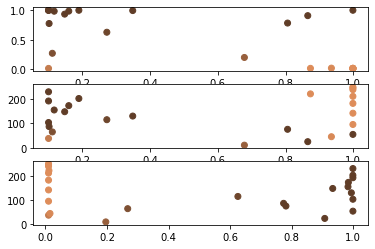

In [215]:
data, targets = get_data() 

level = 1
lower = 0.4
steps = 3
budget = 100

bounds = None
params = []

plt.figure(figsize=(10,16))
for i, b in enumerate(budget_division(budget, how='linear_asc', steps=steps, lower=lower)):
    sample_size = size(i, lower, steps) 
    n_iter = models_at_sample_size(b, sample_size, 'rf')
    
    rows = int(len(data) * sample_size)
    idx = np.random.choice(len(data), rows, replace=False) 
    sampled_X = data[idx,:]
    sampled_y = targets[idx]
    data, targets = get_data() 

    print(Colours.green(f"--- Optimizing Random Forest: {n_iter} models; budget:{b} --- "))
    params = optimize_rfc(sampled_X, sampled_y, level, n_iter, bounds, params)   
    level += 1
#plt.legend(loc="upper right")

# TESTING AREA

In [96]:
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF
X, y = make_friedman2(n_samples=500, noise=0.2, random_state=0)
kernel = DotProduct() + WhiteKernel()
kernel = RBF()
gpr = GaussianProcessRegressor(kernel=kernel,
        random_state=0).fit(X, y)
#gpr.score(X, y)

#gpr.predict(X[:20,:], return_std=True)

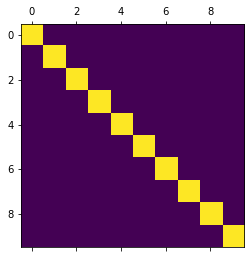

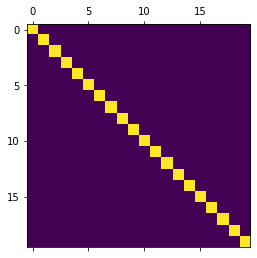

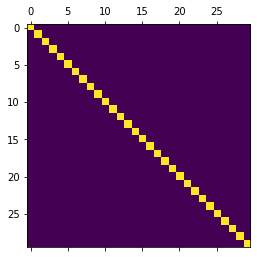

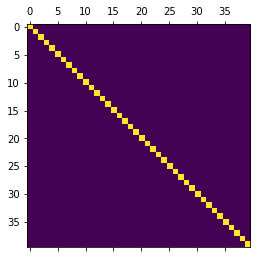

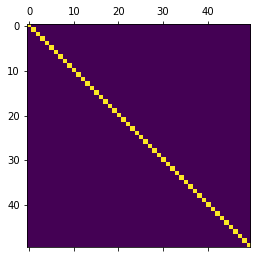

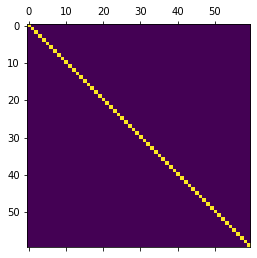

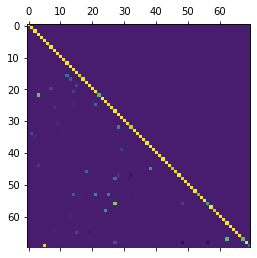

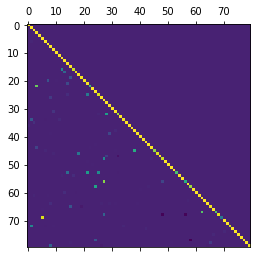

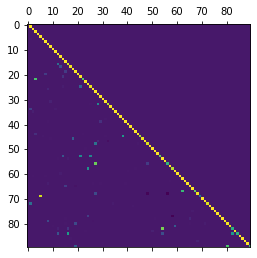

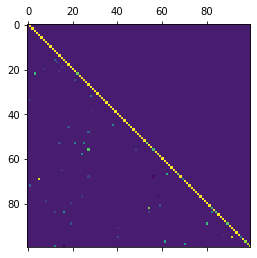

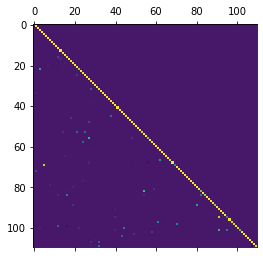

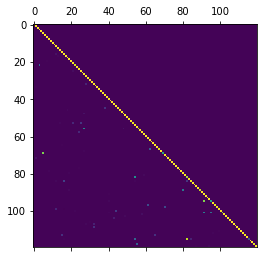

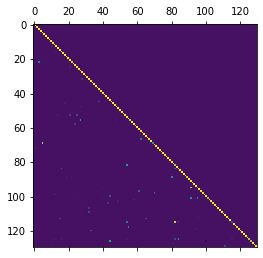

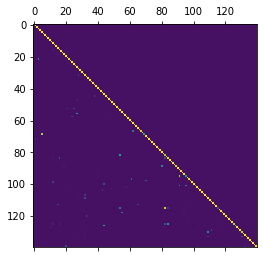

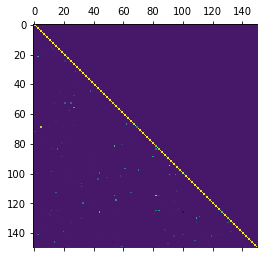

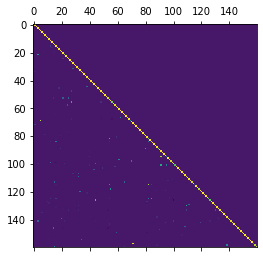

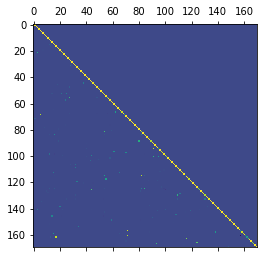

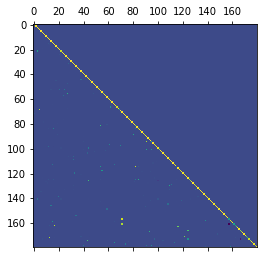

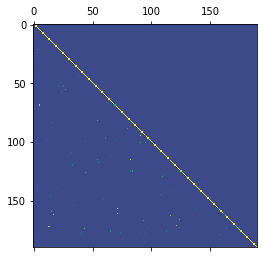

In [100]:
 for i in range(10, 200, 10):
    X, y = make_friedman2(n_samples=i, noise=0.2, random_state=0)
    kernel = DotProduct() + WhiteKernel()
    kernel = RBF()
    gpr = GaussianProcessRegressor(kernel=kernel,
            random_state=0).fit(X, y)
    cholesky = gpr.L_
    plt.matshow(cholesky)
    plt.show()

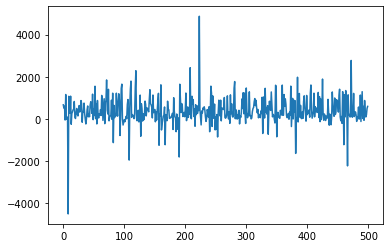

In [71]:
plt.plot(gpr.alpha_)

In [110]:
kernel = RBF()
gpr = GaussianProcessRegressor(kernel=kernel,
        random_state=0).fit(X, y)

In [132]:
kernel = RBF()
gprt = GaussianProcessRegressor(kernel=RBF()) 
gprt.L_ = cholesky

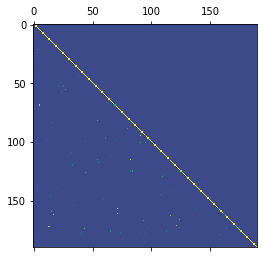

In [126]:
plt.matshow(cholesky)

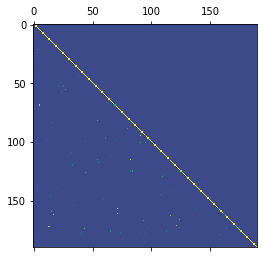

In [127]:
plt.matshow(gprt.L_)

In [141]:
gpr.kernel.diag(X)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [138]:
gprt.fit(X, y)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=RBF(length_scale=1), n_restarts_optimizer=0,
                         normalize_y=False, optimizer='fmin_l_bfgs_b',
                         random_state=None)

In [134]:
gprt.predict(X[:20,:], return_std=True)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.]))